In [1]:
# credit-risk-model\notebooks\01_data_exploration.ipynb

### 01 - Data Exploration and Preprocessing

This notebook focuses on the initial Exploratory Data Analysis (EDA) of the `data.csv` dataset. The goal is to understand the dataset's structure, identify data quality issues (missing values, outliers), analyze feature distributions, and uncover patterns that will guide subsequent feature engineering and model development.

#### Table of Contents
1.  Setup and Data Loading
2.  Data Overview
3.  Summary Statistics
4.  Distribution of Numerical Features
5.  Distribution of Categorical Features
6.  Correlation Analysis
7.  Identifying Missing Values
8.  Outlier Detection
9.  Key Insights

##### 1. Setup and Data Loading

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# remove warnings while loading and plotting    
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
sns.set_style('whitegrid')

# Define the path to the raw data file
DATA_PATH = '../data/raw/data.csv'

# Load the dataset
try:
    df = pd.read_csv(DATA_PATH)
    print(f"Successfully loaded data from {DATA_PATH}")
except FileNotFoundError:
    print(f"Error: The file {DATA_PATH} was not found. Please ensure it's in the correct directory.")
    df = None # Set df to None to prevent further errors
except Exception as e:
    print(f"An error occurred while loading the data: {e}")
    df = None

Successfully loaded data from ../data/raw/data.csv


In [22]:
# 2. Data Overview
print("\n--- Data Head ---")
print(df.head())

print("\n--- Data Shape ---")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

print("\n--- Data Info ---")
df.info()

print("\n--- Data Types ---")
print(df.dtypes)

# Convert 'TransactionStartTime' to datetime for better temporal analysis later
# This is a pre-emptive step for potential feature extraction later, but good for EDA.
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'], errors='coerce')


print("\n--- Data Missing Values ---")
print(df.isnull().sum())


--- Data Head ---
         TransactionId         BatchId       AccountId       SubscriptionId       CustomerId CurrencyCode  CountryCode    ProviderId     ProductId     ProductCategory    ChannelId   Amount  Value      TransactionStartTime  PricingStrategy  FraudResult
0  TransactionId_76871   BatchId_36123  AccountId_3957   SubscriptionId_887  CustomerId_4406          UGX          256  ProviderId_6  ProductId_10             airtime  ChannelId_3   1000.0   1000 2018-11-15 02:18:49+00:00                2            0
1  TransactionId_73770   BatchId_15642  AccountId_4841  SubscriptionId_3829  CustomerId_4406          UGX          256  ProviderId_4   ProductId_6  financial_services  ChannelId_2    -20.0     20 2018-11-15 02:19:08+00:00                2            0
2  TransactionId_26203   BatchId_53941  AccountId_4229   SubscriptionId_222  CustomerId_4683          UGX          256  ProviderId_6   ProductId_1             airtime  ChannelId_3    500.0    500 2018-11-15 02:44:21+00:00    

In [14]:
# 3. Summary Statistics
print("\n--- Summary Statistics for Numerical Features ---")
print(df.describe().T)

print("\n--- Summary Statistics for Categorical Features ---")
# Exclude TransactionStartTime as it's datetime now and TransactionId/BatchId/AccountId/CustomerId/SubscriptionId as they are identifiers
categorical_cols = df.select_dtypes(include='object').columns.tolist()
# Add FraudResult, CountryCode, ProviderId, ProductId if they are treated as categorical later
potentially_categorical = ['FraudResult', 'CountryCode', 'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'PricingStrategy', 'CurrencyCode']
for col in potentially_categorical:
    if col not in categorical_cols and col in df.columns:
        # Check if numerical column has few unique values to be considered categorical
        if df[col].nunique() < 50 or df[col].dtype == 'int64': # Heuristic for potentially categorical numerics
            categorical_cols.append(col)

# Filter out IDs and datetime column
categorical_cols = [col for col in categorical_cols if col not in ['TransactionId', 'BatchId', 'AccountId', 'CustomerId', 'SubscriptionId', 'TransactionStartTime']]

if categorical_cols:
    print(df[categorical_cols].describe().T)
else:
    print("No readily identifiable categorical columns for summary statistics, aside from IDs.")

# Check unique values for ID columns to understand their cardinality
id_cols = ['TransactionId', 'BatchId', 'AccountId', 'CustomerId', 'SubscriptionId']
print("\n--- Unique counts for ID features ---")
for col in id_cols:
    if col in df.columns:
        print(f"{col}: {df[col].nunique()} unique values")


--- Summary Statistics for Numerical Features ---
                   count         mean            std        min    25%     50%     75%        max
CountryCode      95662.0   256.000000       0.000000      256.0  256.0   256.0   256.0      256.0
Amount           95662.0  6717.846433  123306.797164 -1000000.0  -50.0  1000.0  2800.0  9880000.0
Value            95662.0  9900.583941  123122.087776        2.0  275.0  1000.0  5000.0  9880000.0
PricingStrategy  95662.0     2.255974       0.732924        0.0    2.0     2.0     2.0        4.0
FraudResult      95662.0     0.002018       0.044872        0.0    0.0     0.0     0.0        1.0

--- Summary Statistics for Categorical Features ---
                   count        mean       std    min    25%    50%    75%    max
FraudResult      95662.0    0.002018  0.044872    0.0    0.0    0.0    0.0    1.0
CountryCode      95662.0  256.000000  0.000000  256.0  256.0  256.0  256.0  256.0
PricingStrategy  95662.0    2.255974  0.732924    0.0    2.0  


--- Distributions of Numerical Features ---


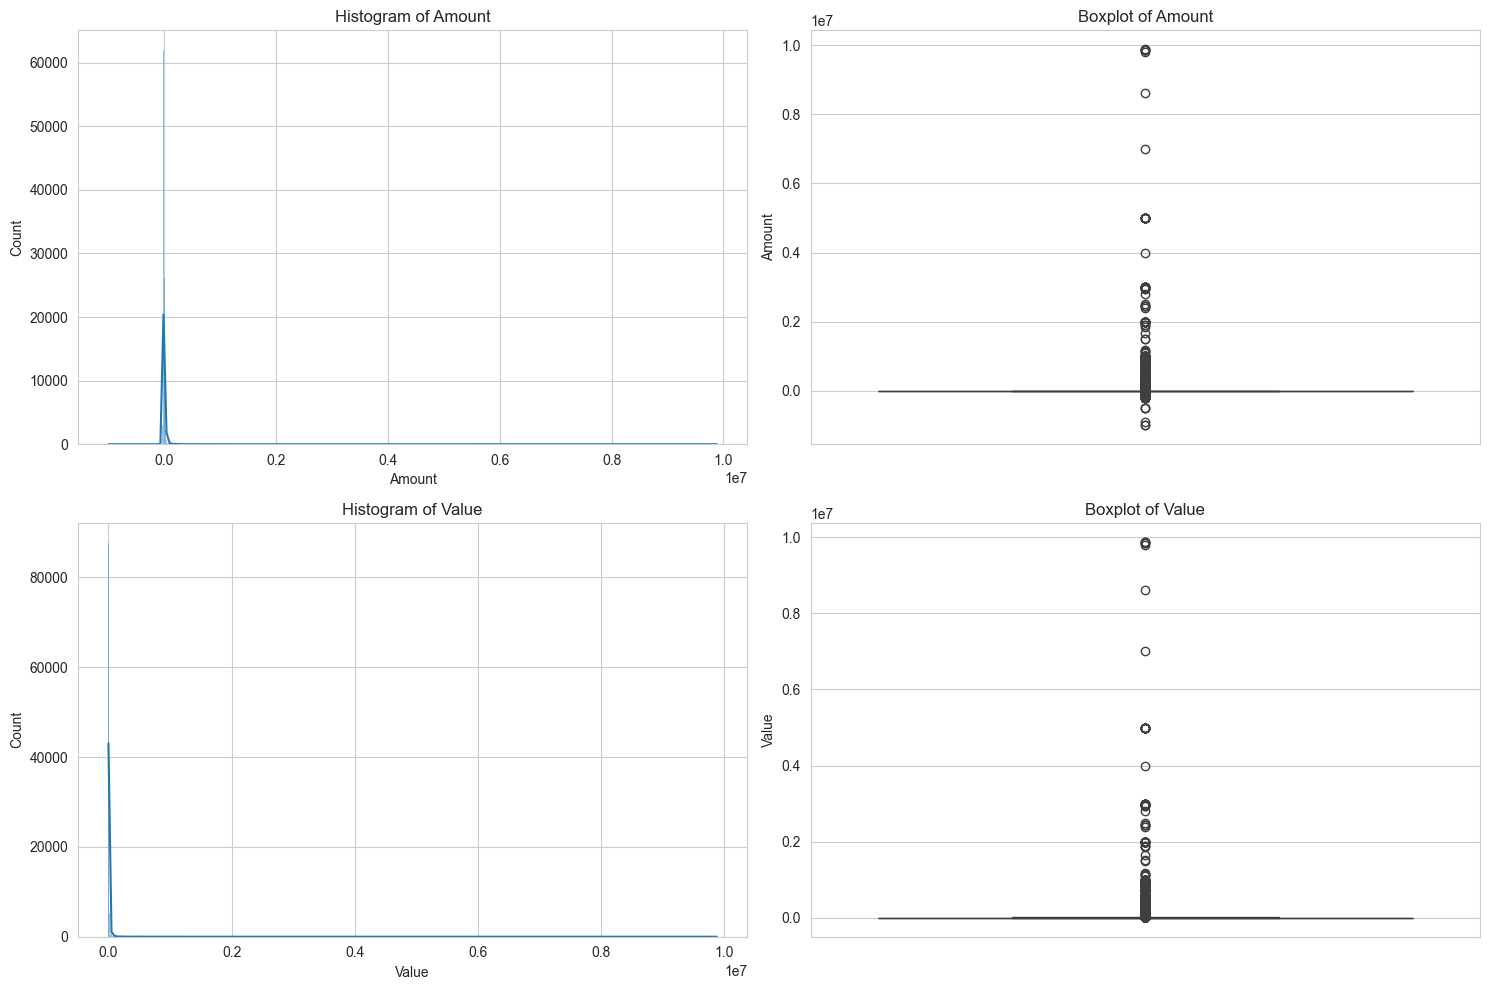


--- Distribution of FraudResult ---


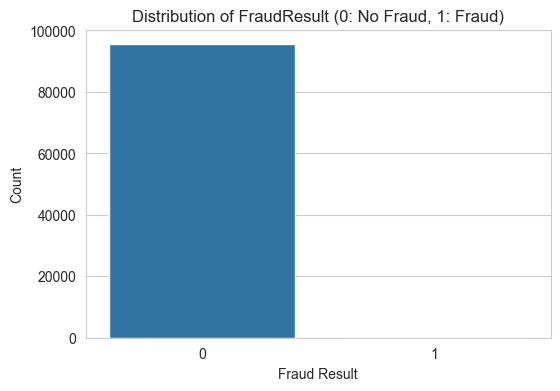

FraudResult
0    0.997982
1    0.002018
Name: proportion, dtype: float64


In [15]:
# 4. Distribution of Numerical Features
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
# Filter out potential categorical-like numericals or IDs that aren't truly numerical for distribution plots
numerical_for_dist = [col for col in numerical_cols if col not in ['FraudResult', 'CountryCode', 'ProviderId', 'TransactionId', 'BatchId', 'AccountId', 'CustomerId', 'SubscriptionId'] and df[col].nunique() > 50]

print("\n--- Distributions of Numerical Features ---")
if numerical_for_dist:
    plt.figure(figsize=(15, 5 * len(numerical_for_dist)))
    for i, col in enumerate(numerical_for_dist):
        plt.subplot(len(numerical_for_dist), 2, 2*i + 1)
        sns.histplot(df[col].dropna(), kde=True)
        plt.title(f'Histogram of {col}')

        plt.subplot(len(numerical_for_dist), 2, 2*i + 2)
        sns.boxplot(y=df[col].dropna())
        plt.title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()
else:
    print("No suitable numerical features for distribution plots found.")

# Distribution of FraudResult (our current binary target for context)
if 'FraudResult' in df.columns:
    print("\n--- Distribution of FraudResult ---")
    plt.figure(figsize=(6, 4))
    sns.countplot(x='FraudResult', data=df)
    plt.title('Distribution of FraudResult (0: No Fraud, 1: Fraud)')
    plt.xlabel('Fraud Result')
    plt.ylabel('Count')
    plt.show()
    print(df['FraudResult'].value_counts(normalize=True))
else:
    print("'FraudResult' column not found.")

In [ ]:
# display the count of trans that has 1 fraudresult
df['FraudResult'].value_counts()  # 0 = no fraud, 1 = fraud

FraudResult
0    95469
1      193
Name: count, dtype: int64


--- List of Categorical Features for Distribution Plots ---
['ChannelId', 'CurrencyCode', 'ProductId', 'ProviderId', 'ProductCategory', 'PricingStrategy', 'CountryCode']

--- Distributions of Categorical Features ---


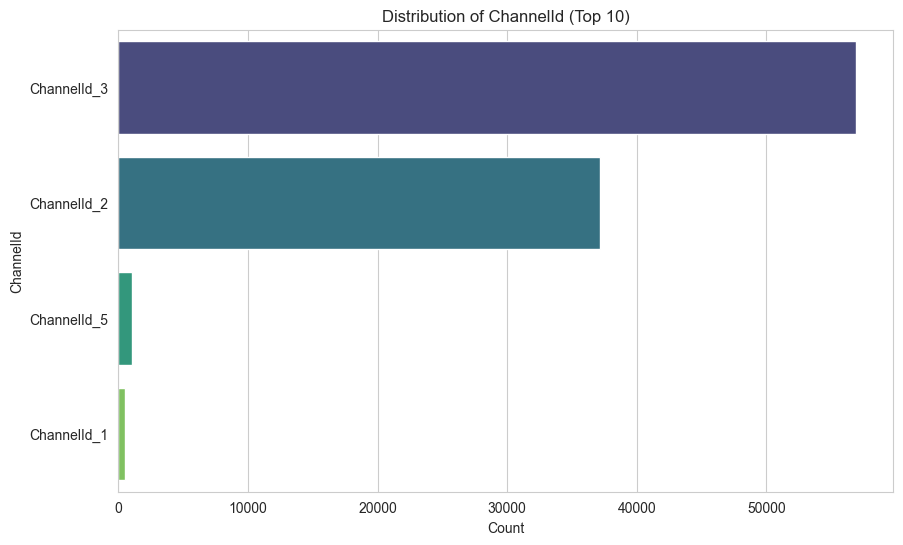

Value counts for ChannelId:
ChannelId
ChannelId_3    0.595168
ChannelId_2    0.388252
ChannelId_5    0.010955
ChannelId_1    0.005624
Name: proportion, dtype: float64


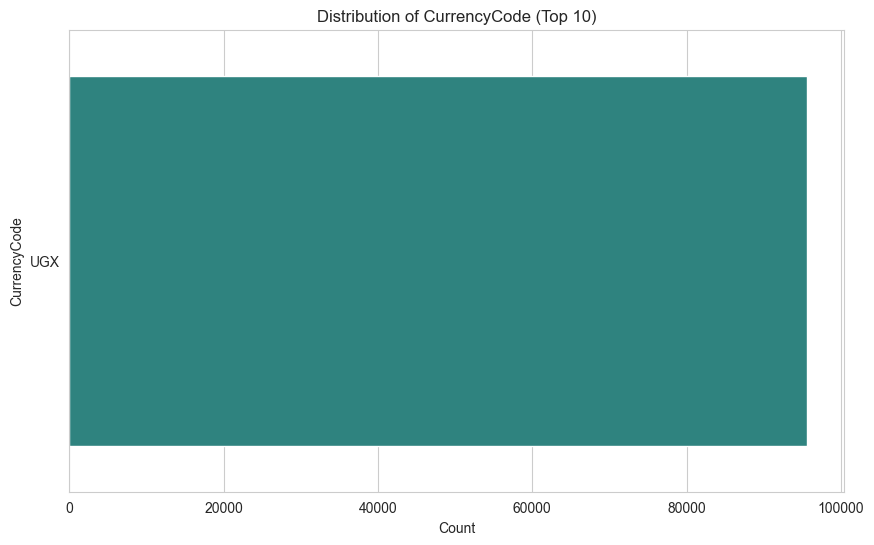

Value counts for CurrencyCode:
CurrencyCode
UGX    1.0
Name: proportion, dtype: float64


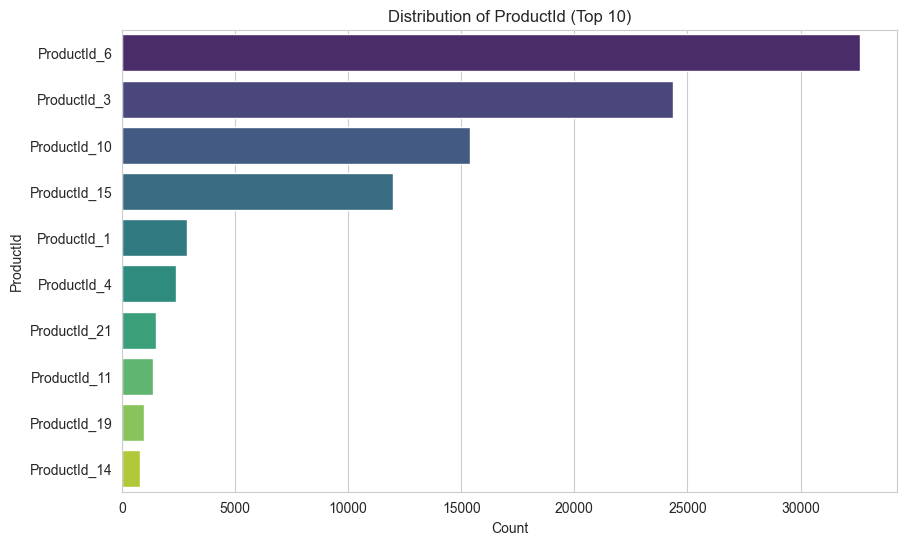

Value counts for ProductId:
ProductId
ProductId_6     0.341149
ProductId_3     0.254479
ProductId_10    0.160816
ProductId_15    0.125065
ProductId_1     0.030158
ProductId_4     0.025120
ProductId_21    0.015806
ProductId_11    0.014394
ProductId_19    0.010088
ProductId_14    0.008248
ProductId_13    0.003094
ProductId_2     0.002467
ProductId_20    0.002258
ProductId_8     0.002059
ProductId_24    0.001829
ProductId_22    0.001171
ProductId_7     0.000899
ProductId_27    0.000324
ProductId_5     0.000261
ProductId_9     0.000178
ProductId_16    0.000105
ProductId_12    0.000021
ProductId_23    0.000010
Name: proportion, dtype: float64


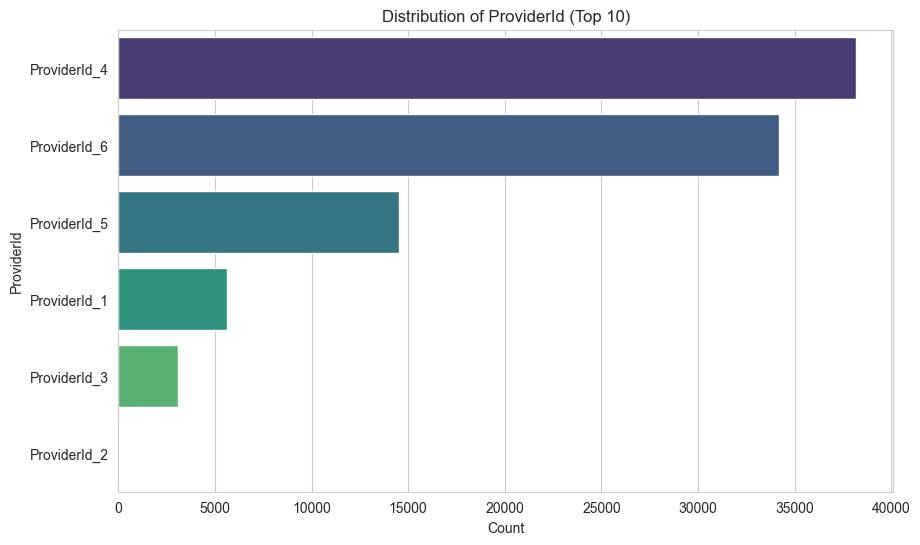

Value counts for ProviderId:
ProviderId
ProviderId_4    0.399208
ProviderId_6    0.357362
ProviderId_5    0.152014
ProviderId_1    0.058989
ProviderId_3    0.032239
ProviderId_2    0.000188
Name: proportion, dtype: float64


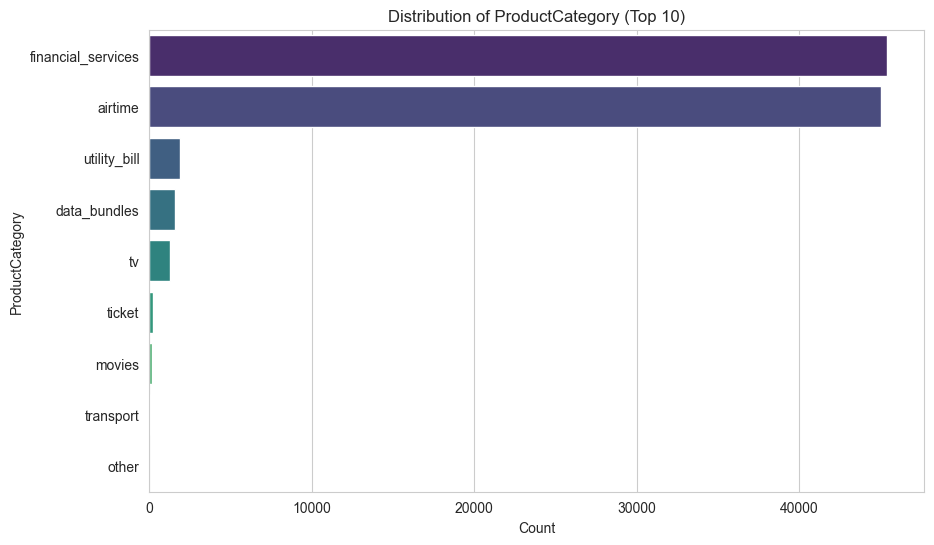

Value counts for ProductCategory:
ProductCategory
financial_services    0.474640
airtime               0.470688
utility_bill          0.020071
data_bundles          0.016861
tv                    0.013370
ticket                0.002258
movies                0.001829
transport             0.000261
other                 0.000021
Name: proportion, dtype: float64


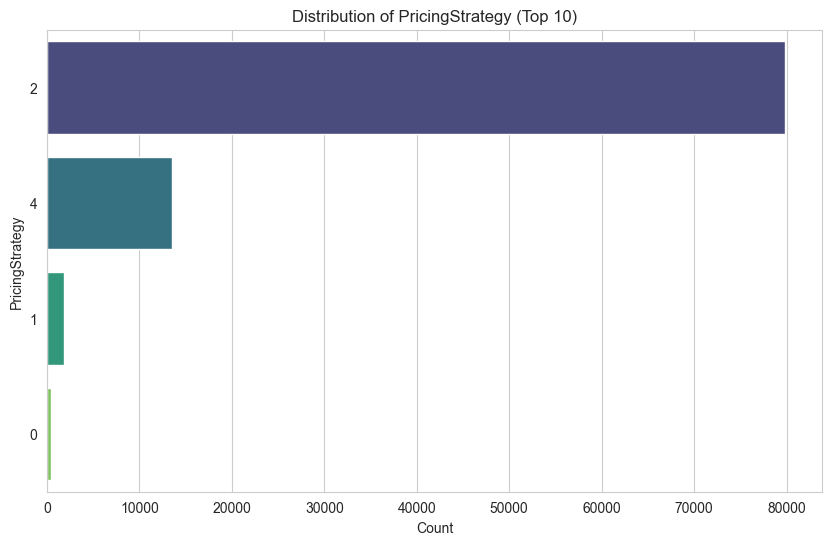

Value counts for PricingStrategy:
PricingStrategy
2    0.834689
4    0.141770
1    0.019517
0    0.004025
Name: proportion, dtype: float64


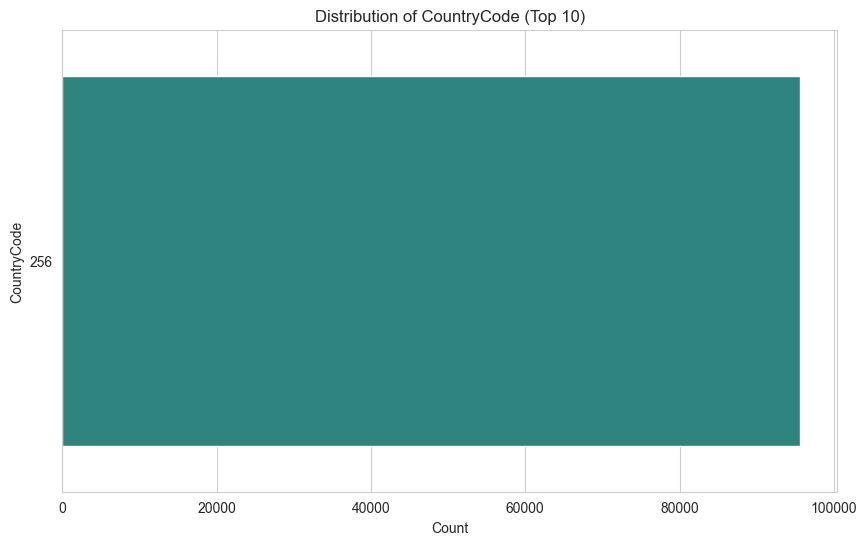

Value counts for CountryCode:
CountryCode
256    1.0
Name: proportion, dtype: float64


In [25]:
# 5. Distribution of Categorical Features
# Re-identify categorical columns more strictly for plotting, excluding high-cardinality IDs
categorical_for_plot = [col for col in df.select_dtypes(include='object').columns.tolist() if col not in ['TransactionId', 'BatchId', 'AccountId', 'CustomerId', 'SubscriptionId', 'TransactionStartTime']]
# Also include columns that are numerical but truly categorical (e.g., CountryCode, PricingStrategy, FraudResult if int)
for col in ['CountryCode', 'PricingStrategy']:
    if col in df.columns and df[col].nunique() < 100: # Heuristic: if less than 100 unique values for numerical, treat as categorical for plotting
        categorical_for_plot.append(col)

# Ensure unique values (might add duplicates if a column is object and also falls into the numeric-as-categorical heuristic)
categorical_for_plot = list(set(categorical_for_plot))
print("\n--- List of Categorical Features for Distribution Plots ---")
print(categorical_for_plot)

print("\n--- Distributions of Categorical Features ---")
if categorical_for_plot:
    # Limit to top 10 categories for highly cardinal categorical features for readability
    for col in categorical_for_plot:
        plt.figure(figsize=(10, 6))
        # Get top N categories for plotting
        top_n = df[col].value_counts().nlargest(10).index
        sns.countplot(y=df[col], order=top_n, palette='viridis')
        plt.title(f'Distribution of {col} (Top 10)')
        plt.xlabel('Count')
        plt.ylabel(col)
        plt.show()
        print(f"Value counts for {col}:\n{df[col].value_counts(normalize=True)}")
else:
    print("No suitable categorical features for distribution plots found.")


--- Correlation Matrix of Numerical Features ---


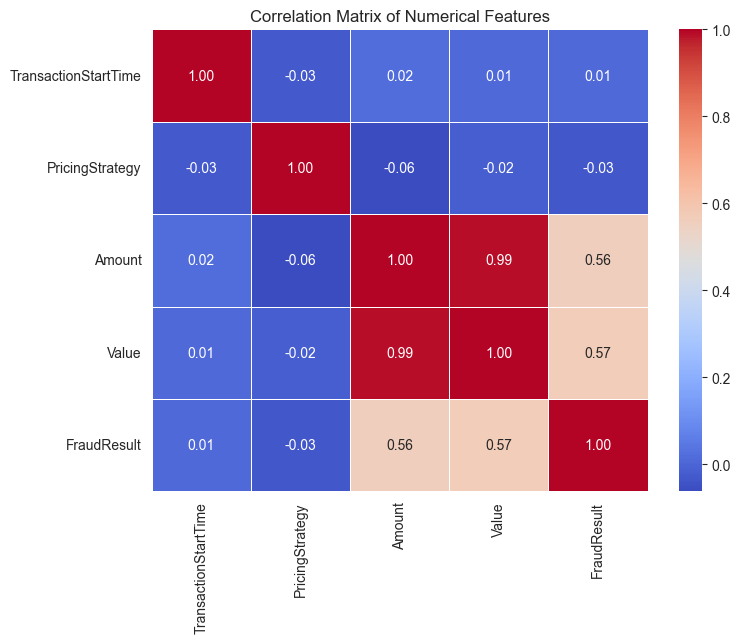

Correlation matrix:
                       TransactionStartTime  PricingStrategy    Amount     Value  FraudResult
TransactionStartTime              1.000000        -0.028344  0.019277  0.012503     0.012008
PricingStrategy                  -0.028344         1.000000 -0.061931 -0.017020    -0.033821
Amount                            0.019277        -0.061931  1.000000  0.989692     0.557370
Value                             0.012503        -0.017020  0.989692  1.000000     0.566739
FraudResult                       0.012008        -0.033821  0.557370  0.566739     1.000000


In [34]:
# 6. Correlation Analysis (Numerical Features)
# Re-selecting numerical columns, excluding IDs and FraudResult for now as it's binary
numeric_cols_for_corr = df[['TransactionStartTime', 'PricingStrategy', 'Amount', 'Value', 'FraudResult']].columns.tolist() # Only Amount and Value are continuous numerical

print("\n--- Correlation Matrix of Numerical Features ---")
if numeric_cols_for_corr:
    corr_matrix = df[numeric_cols_for_corr].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Matrix of Numerical Features')
    plt.show()
    print("Correlation matrix:\n", corr_matrix)
else:
    print("No suitable numerical features for correlation analysis found.")

In [32]:
print(df['ProductCategory'].value_counts())

ProductCategory
financial_services    45405
airtime               45027
utility_bill           1920
data_bundles           1613
tv                     1279
ticket                  216
movies                  175
transport                25
other                     2
Name: count, dtype: int64


In [ ]:
# 7. Identifying Missing Values
print("\n--- Missing Values ---")
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing_values, 'Missing Percentage': missing_percentage})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing Percentage', ascending=False)

if not missing_df.empty:
    print(missing_df)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=missing_df.index, y=missing_df['Missing Percentage'], palette='Reds_d')
    plt.title('Percentage of Missing Values Per Column')
    plt.xlabel('Columns')
    plt.ylabel('Missing Percentage (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No missing values found in the dataset.")


--- Missing Values ---
No missing values found in the dataset.



--- Outlier Detection for Amount and Value ---


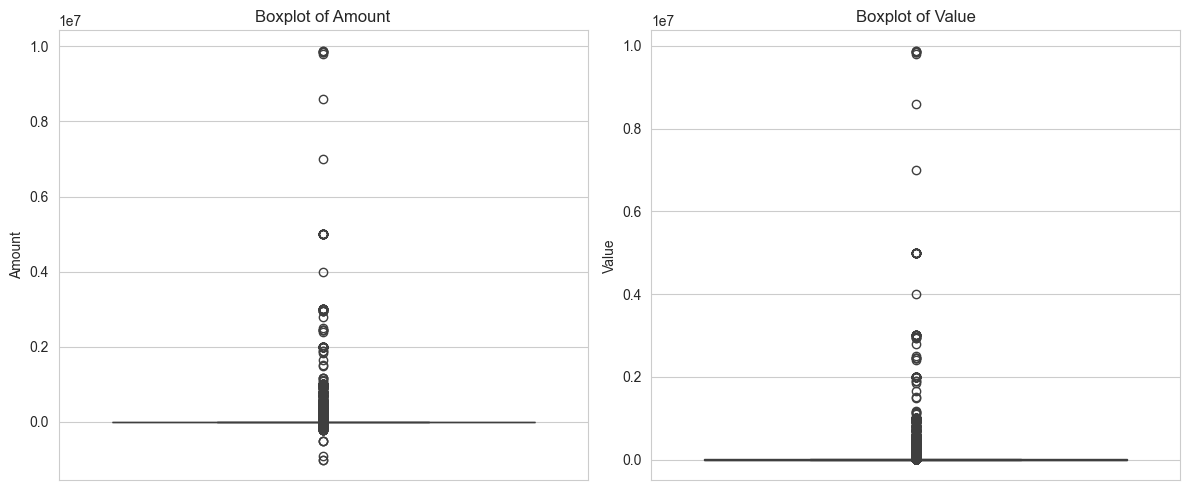

In [27]:
# 8. Outlier Detection (using Box Plots for key numerical features)
print("\n--- Outlier Detection for Amount and Value ---")
numerical_for_outliers = ['Amount', 'Value']

plt.figure(figsize=(12, 5))
for i, col in enumerate(numerical_for_outliers):
    plt.subplot(1, 2, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

#### Key Insights:

1. **Data Overview**:
   - The dataset contains 95,662 rows and 16 columns.
   - No missing values were found in any of the columns.
   - The data types include objects (strings), integers, floats, and datetime.

2. **Summary Statistics**:
   - The `FraudResult` column indicates that fraud is rare (only ~0.2% of transactions are fraudulent).
   - The `Amount` and `Value` columns show a wide range, with some extreme values (e.g., max `Amount` is 9,880,000, min is -1,000,000).
   - `PricingStrategy` has values ranging from 0 to 4, with 2 being the most common.

3. **Distribution of Numerical Features**:
   - The `Amount` and `Value` distributions are highly skewed, with most transactions concentrated around smaller values but some extreme outliers.
   - `FraudResult` is imbalanced, with very few fraudulent transactions.

4. **Distribution of Categorical Features**:
   - `CurrencyCode` is dominated by one code (likely UGX, as seen in the head of the dataset).
   - `ProductCategory` includes categories like "airtime," "financial_services," and "utility_bill."
   - `ChannelId` shows which channels are most frequently used for transactions.

5. **Correlation Analysis**:
   - The notebook hints at a correlation analysis, but the actual plots/results are not shown. It would be useful to explore correlations between features like `Amount`, `Value`. Elaborated on correlations among features later on in the `Key Insights from Feature Correlation Analysis ` section.

6. **Outlier Detection**:
   - The `Amount` and `Value` columns have extreme outliers (e.g., very high or negative values). These could represent errors or genuine high-value transactions and should be investigated further.

7. **Temporal Analysis**:
   - There no a big correlation between `TransactionStartTime` and `Fraud`.


---

##### Key Insights from Feature Correlation Analysis 

The correlation matrix reveals critical relationships between transactional features and fraud outcomes:

| Feature                | Key Observation                                                                 | Business Implication                                                                 |
|------------------------|---------------------------------------------------------------------------------|-------------------------------------------------------------------------------------|
| **Amount** & **Value** | Extremely high correlation (0.99)                                              | **Multicollinearity risk**—consider using only one in modeling to avoid redundancy. |
| **FraudResult**        | Strong correlation with `Amount` (0.56) and `Value` (0.57)                     | Transaction magnitude is a **key fraud signal**—prioritize for feature engineering. |
| **PricingStrategy**    | Weak negative correlation with fraud (-0.03)                                   | May require deeper segmentation (e.g., by product category) to uncover hidden patterns. |
| **TransactionStartTime** | Near-zero correlation with fraud (0.01)                                       | Likely **low predictive power** unless transformed (e.g., aggregated over time windows). |


